#Introduction to memory profiling

> Objectives:
> * Be introduced to memory profiling using different tools
> * Some small introduction to time profiling in IPython too


##ipython_memwatcher

Our recommended way to profile memory consumption for this tutorial will be [ipython_memwatcher](https://pypi.python.org/pypi/ipython_memwatcher):


In [1]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [1] used 0.031 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 30.797 MiB


In [2]:
# Let's create a big object
a = [i for i in range(1000*1000)]

In [2] used 31.250 MiB RAM in 0.127s, peaked 0.000 MiB above current, total RAM usage 62.047 MiB


In [3]:
# Get some measurements from the last executed cell:
meas = mw.measurements
meas

Measurements(memory_delta=31.25, time_delta=0.12670516967773438, memory_peak=0, memory_usage=62.046875)

In [3] used 0.027 MiB RAM in 0.009s, peaked 0.000 MiB above current, total RAM usage 62.074 MiB


In [4]:
# MemWatcher.measurements is a named tuple.  We can easily get info out of it:
meas.memory_delta

31.25

In [4] used 0.016 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 62.090 MiB


In [5]:
# This takes betweed 32 ~ 35 bytes per element:
meas.memory_delta * (2**20) / 1e6

32.768

In [5] used 0.000 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 62.090 MiB


In [6]:
# What are the elements made from?
type(a[0])

int

In [6] used 0.004 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 62.094 MiB


In [7]:
# How much memory take an int?
# Beware: the size below will depend on whether you are using a 32-bit or 64-bit Python
import sys
sys.getsizeof(a[0])

24

In [7] used 0.004 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 62.098 MiB


But 24 is quite less than 32~35.  Where this overhead comes from?

##objgraph

Graph written to /tmp/objgraph-Ru8EyF.dot (4 nodes)
Image generated as simple-list.png


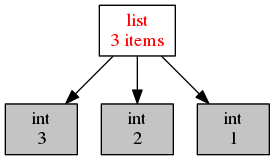

In [8] used 0.070 MiB RAM in 0.096s, peaked 0.000 MiB above current, total RAM usage 62.168 MiB


In [8]:
# Let's introduce the objgraph package and see
b = [1,2,3]
import objgraph
objgraph.show_refs([b], filename='simple-list.png')
from IPython.core.display import Image 
Image('simple-list.png')

So, the list is an structure that takes a pointer (8 bytes in 64-bit platforms) per every element in the list.  If we add this to the 24 bytes per int, then we have 32 bytes per element, which is close to the computed 32~35 bytes above.  The remaining difference is probably due to how Python handles memory internally (over-allocation). 

##memory_profiler

[memory_profiler](https://pypi.python.org/pypi/memory_profiler) is a basic module for memory profiling that many others use (like the `ipython_memwatcher` above) and it interacts well with ipython, so it is worth to see how it works:

In [9]:
%load_ext memory_profiler

In [9] used 0.113 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 62.281 MiB


In [10]:
# Use %memit magic command exposed by memory_profiler
%memit b = [i for i in range(1000*1000)]

peak memory: 133.71 MiB, increment: 71.43 MiB
In [10] used 71.566 MiB RAM in 0.422s, peaked 0.000 MiB above current, total RAM usage 133.848 MiB


Please note that the `peak_memory` in this case is different than the `peaked_memory` reported by ipython_memwatcher package.

##Guppy

Guppy is nice for having an overview of how different structures are using our memory:

In [11]:
from guppy import hpy; hp=hpy()
hp.heap()

Partition of a set of 2128438 objects. Total size = 81725216 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0 2004742  94 48113808  59  48113808  59 int
     1   1180   0 16434528  20  64548336  79 list
     2  57604   3  5178296   6  69726632  85 str
     3  30884   1  2677520   3  72404152  89 tuple
     4   1745   0  1713944   2  74118096  91 dict (no owner)
     5    436   0  1256416   2  75374512  92 dict of module
     6   7828   0  1001984   1  76376496  93 types.CodeType
     7   7722   0   926640   1  77303136  95 function
     8    943   0   849784   1  78152920  96 type
     9    943   0   779752   1  78932672  97 dict of type
<562 more rows. Type e.g. '_.more' to view.>

In [11] used 32.266 MiB RAM in 3.138s, peaked 0.000 MiB above current, total RAM usage 166.113 MiB


In [12]:
# Size of the list (beware, this does not include the contents!)
hp.iso(a)

Partition of a set of 1 object. Total size = 8126536 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0      1 100  8126536 100   8126536 100 list

In [12] used 0.000 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 166.113 MiB


##%time and %timeit

In [13]:
# IPython provides a magic command to see how much time a command takes to run
%time asum = sum(a)

CPU times: user 19.8 ms, sys: 0 ns, total: 19.8 ms
Wall time: 27.2 ms
In [13] used 0.000 MiB RAM in 0.031s, peaked 0.000 MiB above current, total RAM usage 166.113 MiB


Note that `%time` offers quite detailed statistics on the time spent.

Also, the time reported by MemoryWatcher has a typical overhead of 3~5 ms over the time reported by %time, so when the times to measure are about this order then it is better to rely on the %time (or %timeit below) values.  

In [14]:
# We have another way to measure timings doing several loops and getting the mean
%timeit bsum = sum(a)

100 loops, best of 3: 6.95 ms per loop
In [14] used 0.000 MiB RAM in 2.964s, peaked 0.000 MiB above current, total RAM usage 166.113 MiB


In [15]:
# However, one must notice that %timeit does not return the result of expressions
bsum

NameError: name 'bsum' is not defined

In [15] used 0.953 MiB RAM in 0.071s, peaked 0.000 MiB above current, total RAM usage 167.066 MiB


However, %timeit also permits to retrieve the measured times in loops with the -o flag:

In [16]:
t = %timeit -o sum(a)
print(t.all_runs)
print(t.best)

100 loops, best of 3: 7.06 ms per loop
[0.7086479663848877, 0.7063848972320557, 0.7180221080780029]
0.00706384897232
In [16] used 0.000 MiB RAM in 3.026s, peaked 0.000 MiB above current, total RAM usage 167.066 MiB


And one can specify the number of loops (-n) and the number of repetitions (-r):

In [17]:
t = %timeit -r1 -n1 -o sum(a)
print(t.all_runs)
print(t.best)

1 loops, best of 1: 16.2 ms per loop
[0.016164064407348633]
0.0161640644073
In [17] used 0.000 MiB RAM in 0.023s, peaked 0.000 MiB above current, total RAM usage 167.066 MiB


### Exercise 1

Provided a dictionary like:

```
d = dict(("key: %i"%i, i*2) for i in a)
```

Try to guess how much RAM it uses.

Why do you think it takes more space than a list?
*Hint*: Use the `objgraph` package on a short dictionary so as to better see the data structure. 